Epoch [50/700], Train Loss: 0.3550, Val Loss: 0.1489, MAE: 13.50, Corr: 0.995
Epoch [100/700], Train Loss: 0.3361, Val Loss: 0.1095, MAE: 9.56, Corr: 0.996
Epoch [150/700], Train Loss: 0.2916, Val Loss: 0.1058, MAE: 9.26, Corr: 0.996
Epoch [200/700], Train Loss: 0.2705, Val Loss: 0.1060, MAE: 9.42, Corr: 0.996
Epoch [250/700], Train Loss: 0.2528, Val Loss: 0.1059, MAE: 9.48, Corr: 0.997
Epoch [300/700], Train Loss: 0.2408, Val Loss: 0.1007, MAE: 8.80, Corr: 0.997
Epoch [350/700], Train Loss: 0.2555, Val Loss: 0.0976, MAE: 8.56, Corr: 0.997
Epoch [400/700], Train Loss: 0.2250, Val Loss: 0.1021, MAE: 8.98, Corr: 0.997
Epoch [450/700], Train Loss: 0.2306, Val Loss: 0.1002, MAE: 8.93, Corr: 0.997
Epoch [500/700], Train Loss: 0.2292, Val Loss: 0.1036, MAE: 9.25, Corr: 0.997
Epoch [550/700], Train Loss: 0.2181, Val Loss: 0.0997, MAE: 8.97, Corr: 0.997
Epoch [600/700], Train Loss: 0.2052, Val Loss: 0.1028, MAE: 9.22, Corr: 0.997
Epoch [650/700], Train Loss: 0.2217, Val Loss: 0.1008, MAE: 9.09

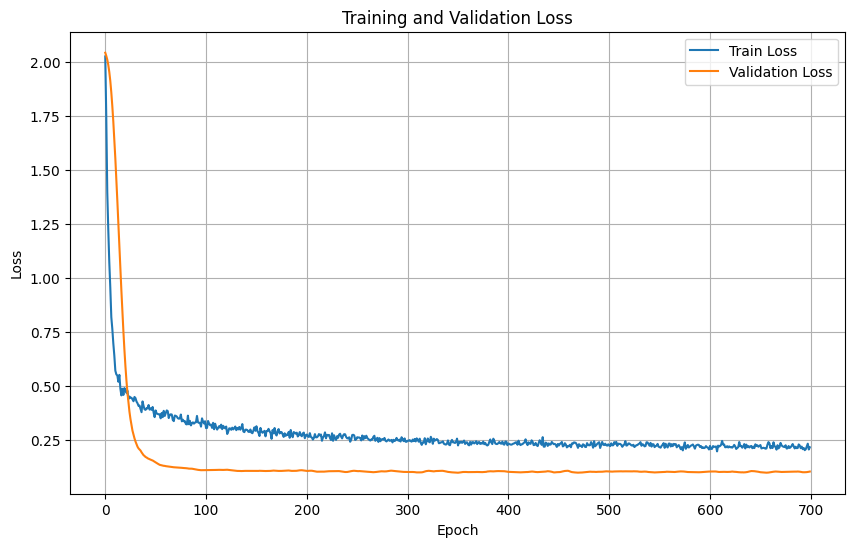


Predicted strength for density=2.5, thickness=0.5: 646.38 MPa


In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import joblib

# Simulated data generation
np.random.seed(42)
n_samples = 1000
density = np.random.uniform(1.0, 3.0, n_samples)
thickness = np.random.uniform(0.1, 1.0, n_samples)
input_data = np.column_stack((density, thickness))

# Simulated mechanical strength with noise and log-transform
target_raw = 500 * (density ** 0.5) * (thickness ** 0.3) + np.random.normal(0, 10, n_samples)
target = np.log(target_raw)

# Normalize input and target data
X = torch.FloatTensor(input_data)
X_mean, X_std = X.mean(dim=0), X.std(dim=0)
X = (X - X_mean) / X_std
y = torch.FloatTensor(target)
y_mean, y_std = y.mean().item(), y.std().item()
y = (y - y_mean) / y_std

# Neural Network
class MaterialModel(nn.Module):
    def __init__(self):
        super(MaterialModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Custom Loss Function
class CustomLoss(nn.Module):
    def __init__(self, alpha=1.26):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()

    def forward(self, predictions, targets):
        mse_loss = self.mse(predictions, targets)
        abs_diff = torch.abs(predictions - targets)
        return mse_loss + self.alpha * torch.mean(abs_diff)

# Train function
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=700):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.unsqueeze(1))
            val_losses.append(val_loss.item())

        if (epoch + 1) % 50 == 0:
            val_preds = np.exp(val_outputs.numpy() * y_std + y_mean)
            val_targets = np.exp(y_val.numpy() * y_std + y_mean)
            mae = mean_absolute_error(val_targets, val_preds)
            correlation, _ = pearsonr(val_preds.flatten(), val_targets.flatten())
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, MAE: {mae:.2f}, Corr: {correlation:.3f}")
    return train_losses, val_losses

# Prepare data split
val_size = int(0.2 * n_samples)
val_idx = np.random.choice(n_samples, val_size, replace=False)
train_idx = np.setdiff1d(np.arange(n_samples), val_idx)
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]
density_val = density[val_idx]

# Initialize model and train
model = MaterialModel()
criterion = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
train_losses, val_losses = train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val)

# Fit correction model on residuals with adjusted scaling
model.eval()
with torch.no_grad():
    val_outputs = model(X_val).numpy()
    val_predictions = np.exp(val_outputs * y_std + y_mean)
    val_targets = np.exp(y_val.numpy() * y_std + y_mean)
    residuals = val_targets - val_predictions
    poly = PolynomialFeatures(degree=2)
    X_corr = poly.fit_transform(density_val.reshape(-1, 1))
    correction_model = LinearRegression().fit(X_corr, residuals * 0.05)  # Reduced to 0.05x
    joblib.dump(correction_model, "residual_correction_model.pkl")
    torch.save(model.state_dict(), 'material_model.pth')  # Save neural network

# Visualize loss
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Prediction Function
def predict_strength(density, thickness):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.FloatTensor([[density, thickness]])
        input_tensor = (input_tensor - X_mean) / X_std
        output = model(input_tensor).item() * y_std + y_mean
        pred_strength = np.exp(output)
        correction_input = poly.transform(np.array([[density]]))
        correction = correction_model.predict(correction_input).ravel()[0]  # Safe scalar
        return float(pred_strength + correction)

# Example Prediction
pred = predict_strength(2.5, 0.5)
print(f"\nPredicted strength for density=2.5, thickness=0.5: {pred:.2f} MPa")